In [1]:
import numpy as np
from io import open
import allel
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import scipy
import pandas
import warnings
warnings.filterwarnings("ignore")

string = 'Data_files/4pops_forProject'
ldprune=False

In [2]:
#%reset
callset_vcf = allel.read_vcf(string +'.vcf')

In [3]:
list(callset_vcf.keys())

samples_fn = 'Data_files/4pops_info.txt'
samples = pandas.read_csv(samples_fn, sep='\t')
samples.head()

chrom = '7'
chrom_index = np.where(callset_vcf['variants/CHROM'] == chrom)[0]
callset_gt = callset_vcf['calldata/GT'][chrom_index]
gt = allel.GenotypeChunkedArray(callset_gt)

iteration 1 retaining 552 removing 448 variants
iteration 1 retaining 341813 removing 271810 variants


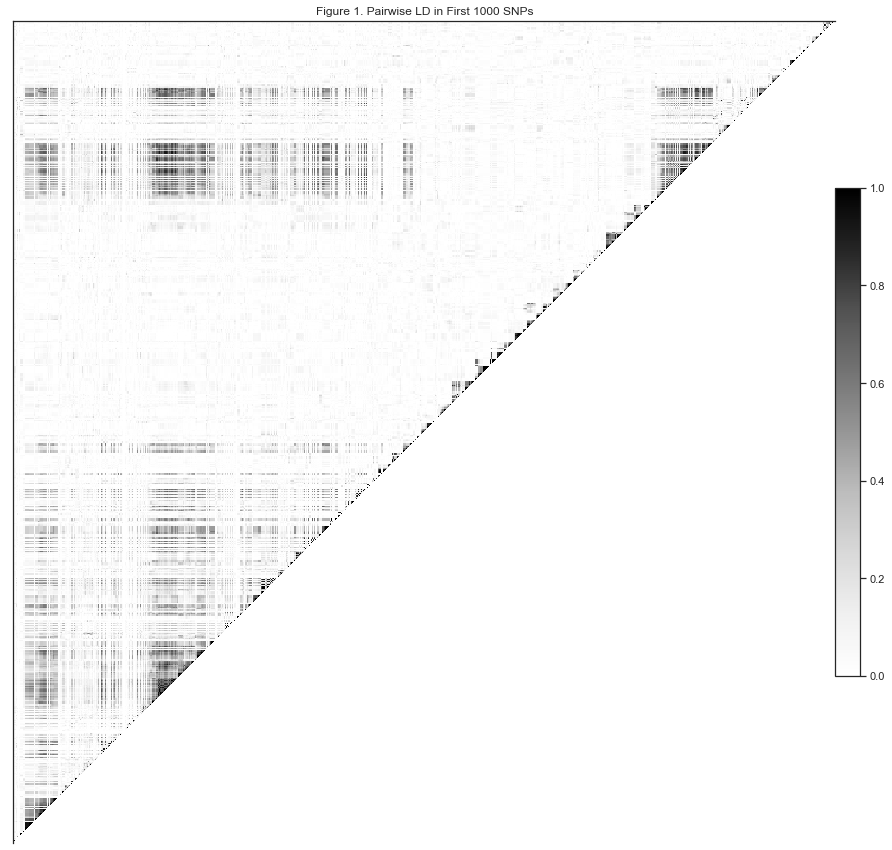

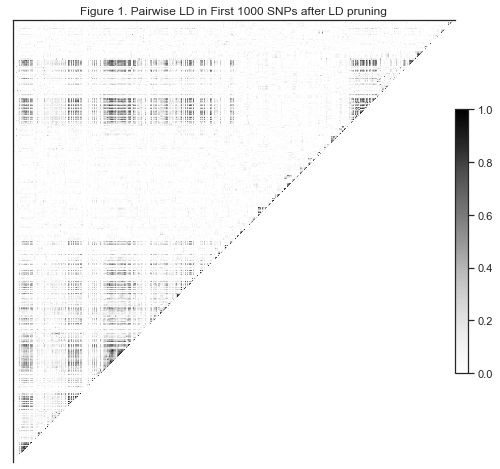

In [4]:
def plot_ld(gt, title):
    m = allel.rogers_huff_r(gt) ** 2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)

plot_ld(gt.to_n_alt()[:1000], 'Figure 1. Pairwise LD in First 1000 SNPs')

def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

gnu = ld_prune(gt.to_n_alt()[:1000], size=500, step=200, threshold=.9, n_iter=1)

plot_ld(gnu, 'Figure 1. Pairwise LD in First 1000 SNPs after LD pruning')

pruned = ld_prune(gt.to_n_alt(), size=500, step=200, threshold=.9, n_iter=1)

In [5]:
if ldprune:
    gt = allel.GenotypeChunkedArray(callset_gt[pruned[:, int(chrom)]])
else:
    pass

In [6]:
samburu_select = np.where(samples.Population.isin({'Samburu'}).values)[0]
ugalla_select = np.where(samples.Population.isin({'Ugalla'}).values)[0]
qenp_select = np.where(samples.Population.isin({'QENP(Mweya)'}).values)[0]
matetsi_select = np.where(samples.Population.isin({'Matetsi'}).values)[0]
defassa_select = np.where(samples.Subspecies.isin({'defassa'}).values)[0]
common_select = np.where(samples.Subspecies.isin({'ellipsiprymnus'}).values)[0]

if ldprune:
    samburu_gt = gt[:, samburu_select]
    ugalla_gt = gt[:, ugalla_select]
    matetsi_gt = gt[:, matetsi_select]
    qenp_gt = gt[:, qenp_select]
else:
    samburu_gt = callset_gt[:, samburu_select]
    ugalla_gt = callset_gt[:, ugalla_select]
    matetsi_gt = callset_gt[:, matetsi_select]
    qenp_gt = callset_gt[:, qenp_select]
    common_gt = callset_gt[:, common_select]

pops = {
    'samburu': samburu_select,
    'ugalla': ugalla_select,
    'qenp': qenp_select,
    'matetsi': matetsi_select, 
    'defassa': defassa_select
}

subspecies = {
    'common': common_select,
    'defassa': defassa_select,
}

ac_subspecies = gt.count_alleles_subpops(subspecies)
ac_subspecies

<AlleleCountsChunkedTable shape=(613623,) dtype=[('common', '<i4', (2,)), ('defassa', '<i4', (2,))]
   nbytes=9.4M cbytes=2.0M cratio=4.6
   values=allel.chunked.storage_zarr.ZarrTable>

In [7]:
ac_subpops = gt.count_alleles_subpops(pops)
ac_subpops

<AlleleCountsChunkedTable shape=(613623,) dtype=[('defassa', '<i4', (2,)), ('matetsi', '<i4', (2,)), ('qenp', '<i4', (2,)), ('samburu', '<i4', (2,)), ('ugalla', '<i4', (2,))]
   nbytes=23.4M cbytes=4.3M cratio=5.4
   values=allel.chunked.storage_zarr.ZarrTable>

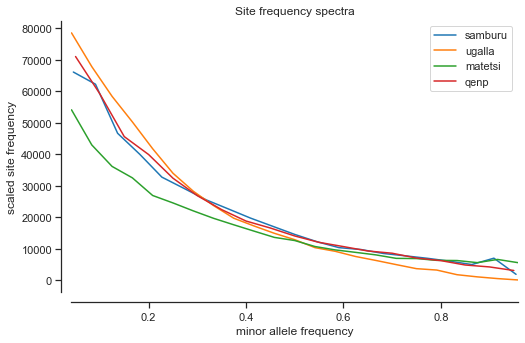

In [8]:
ac2 = ac_subpops['samburu']
ac3 = ac_subpops['ugalla']
ac4 = ac_subpops['matetsi']
ac5 = ac_subpops['qenp']

fig, ax = plt.subplots(figsize=(8, 5))
sns.despine(ax=ax, offset=10)
sfs2 = allel.sfs(ac2[:, 1])
allel.plot_sfs_folded_scaled(sfs2, ax=ax, label='samburu', n=ac2.sum(axis=1).max())
sfs3 = allel.sfs(ac3[:, 1])
allel.plot_sfs_folded_scaled(sfs3, ax=ax, label='ugalla', n=ac3.sum(axis=1).max())
sfs4 = allel.sfs(ac4[:, 1])
allel.plot_sfs_folded_scaled(sfs4, ax=ax, label='matetsi', n=ac4.sum(axis=1).max())
sfs5 = allel.sfs(ac5[:, 1])
allel.plot_sfs_folded_scaled(sfs5, ax=ax, label='qenp', n=ac5.sum(axis=1).max())
ax.legend()
ax.set_title('Site frequency spectra')
# workaround bug in scikit-allel re axis naming
ax.set_xlabel('minor allele frequency');

In [9]:
if ldprune:
    pos = callset_vcf['variants/POS'][chrom_index][pruned[:, int(chrom)]]
else:
    pos = callset_vcf['variants/POS'][chrom_index]
mask = np.where((pos > 0 * (10**8)) & (pos < 2 * (10**8)))[0]
pos = pos[mask]

ac1 = ac_subpops['samburu']
ac2 = ac_subpops['matetsi']
print(pos.shape, ac1.shape, ac2.shape)

ac1 = np.take(ac1, mask, axis=0)
ac2 = np.take(ac2, mask, axis=0)
print(pos.shape, ac1.shape, ac2.shape)

ac3 = ac_subpops['samburu']
ac4 = ac_subpops['ugalla']
ac3 = np.take(ac3, mask, axis=0)
ac4 = np.take(ac4, mask, axis=0)

ac5 = ac_subpops['samburu']
ac6 = ac_subpops['qenp']
ac5 = np.take(ac5, mask, axis=0)
ac6 = np.take(ac6, mask, axis=0)

(613623,) (613623, 2) (613623, 2)
(613623,) (613623, 2) (613623, 2)


In [10]:
def plot_fst_subpops(ac1, ac2, ac3, ac4, ac5, ac6, pos, blen=1500):
    fst, se, vb, _ = allel.blockwise_hudson_fst(ac1, ac2, blen=blen)
    fst2, se2, vb2, _ = allel.blockwise_hudson_fst(ac3, ac4, blen=blen)
    fst3, se3, vb3, _ = allel.blockwise_hudson_fst(ac5, ac6, blen=blen)
    
    # use the per-block average Fst as the Y coordinate
    y = vb
    y2 = vb2
    y3 = vb3
    
    # use the block centres as the X coordinate
    x = allel.moving_statistic(pos, statistic=lambda v: (v[0] + v[-1]) / 2, size=blen)
    
    # plot
    fig, axs = plt.subplots(3, 1, figsize=(10, 6))
    st = fig.suptitle("Differentiation from Samburu", fontsize="x-large")
    plt.subplots_adjust(hspace=0.4)
    #sns.despine(ax=ax, offset=5)
    axs[0].plot(x, y, 'k-', lw=.5)
    axs[0].set_ylabel('$F_{ST}$')
    axs[0].set_xlim(pos.min(), pos.max())
    axs[0].set_ylim(0, 0.85)
    axs[0].title.set_text('Matetsi')
    axs[0].axhline(y=np.percentile(y, 50))
    axs[0].axhline(y=np.percentile(y, 99))
    axs[1].plot(x, y2, 'k-', lw=.5)
    axs[1].set_ylabel('$F_{ST}$')
    axs[1].set_xlim(pos.min(), pos.max())
    axs[1].set_ylim(0, 0.85)
    axs[1].title.set_text('Ugalla')
    axs[1].axhline(y=np.percentile(y2, 50))
    axs[1].axhline(y=np.percentile(y2, 99))
    axs[2].plot(x, y3, 'k-', lw=.5)
    axs[2].set_ylabel('$F_{ST}$')
    axs[2].set_xlabel('Chromosome ' + chrom + ' position (bp)')
    axs[2].set_xlim(pos.min(), pos.max())
    axs[2].set_ylim(0, 0.85)
    axs[2].title.set_text('QENP')
    axs[2].axhline(y=np.percentile(y3, 50))
    axs[2].axhline(y=np.percentile(y3, 99))
    return (x, y, y2, y3)

209


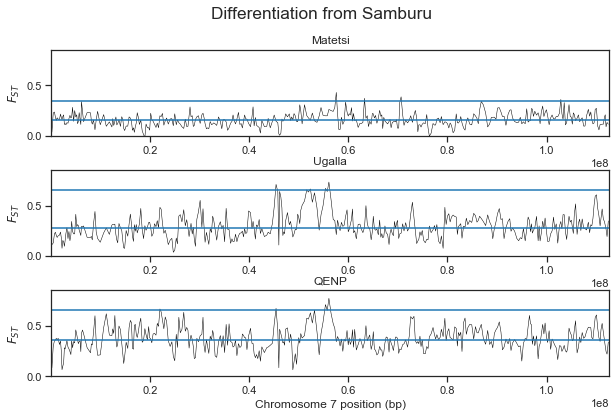

In [11]:
blen=1500
x, y, y2, y3 = plot_fst_subpops(ac1, ac2, ac3, ac4, ac5, ac6, pos, blen=blen)
print(np.argmax(y))

In [12]:
gt_strange = callset_vcf['variants/REF'][chrom_index][blen*np.argmax(y): blen*(np.argmax(y)+1)]
''.join(list(gt_strange))

'AAGCTGCTTAATTGAGGGCAGTCGTGGCGGGGAGGACGGCTCGCCCCGATACGATGCATCAATGTACCTAGAGGACGAGTACGAACACCGGGCACTGATATTGCCATTCCTTCCAGGATCATCTCAGCTACAATAGGGAGAGCACGATGGCCCAAGGGCCGGCTCGAGCACAAGACGCAAGGTGTCCTACTGGACCCGGACATTACACGAAGATCTTAAATCCGGTTAAATGTGAACGGTAATGTTATGCGGTATCGTCAATCGAAGAAACGCGTGCCGCAATAGACGTAGCAAAACGGTCGACCAATGGTCCCGACCCGCCGCTGTCTTGAACTGAGTTTGTTAACCGTAGCGGGGCCACAAATAATCTCCATTGTGAACAGCGCGTCAGTCAGCTGATCAAGGGAATTTCAACGCCATGGGGCCGGAGATTGCTGAGACTACAGGTGCAGGTACGGATTCCCCCAGACGGGGACCGACCAGTCGATCGCGACGTATGCCGGTGATCCTGCCTTGGGCGCCAGTAAATGCCACAGCAACTCTTTTGGCGTGCACGCGCGTATCGTGATATGATGCAATCATTCTCAGTCAAGCTATAAATTCTATACTATTTCGTTCGTTTCCAGAATCACCGTTAGTGCGTTTGTTGCACCAGTTCACCTGGACTAGTCCACGGAACCATGGATTACTCCGGACTGCCGGTTACCCAATCGTGGAACACGTTAGGGGGGTAGGATTGACGGCGCGCGTGATGCGATAGCCCGACACCTTTCCATGAAATCCGTTTGTGCGTTAACACCCACGTCGCACCTCCGTAGTGCGGCGGGCACCCCTCGTCTTGTTAAATCGGTTGGGGGCTCCCAGTCGCACAAGGTTCAGCCGGTCAGATGAAGGGCCCACAAGGCCGATTCCCGGGCGAATGCCTCGGCCTAATGCAGCGTGGTATACCAAGTGCGCAGCCCGGAAGCTCCCGCCATGGTTCGGTAAATCTCCGCAGTC

In [13]:
def plot_fst_samburu_matetsi(ac1, ac2, pos, blen=1500):
    fst, se, vb, _ = allel.blockwise_hudson_fst(ac1, ac2, blen=blen)
    
    # use the per-block average Fst as the Y coordinate
    y = vb
    
    # use the block centres as the X coordinate
    x = allel.moving_statistic(pos, statistic=lambda v: (v[0] + v[-1]) / 2, size=blen)
    
    # plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    st = fig.suptitle("Differentiation", fontsize="x-large")
    plt.subplots_adjust(hspace=0.4)
    #sns.despine(ax=ax, offset=5)
    ax.plot(x, y, 'k-', lw=.5)
    ax.set_ylabel('$F_{ST}$')
    ax.set_xlim(pos.min(), pos.max())
    ax.set_ylim(0, y.max())
    ax.title.set_text('Samburu vs. Matetsi')
    ax.set_xlabel('Chromosome ' + chrom + ' position (bp)')
    ax.axhline(y=np.percentile(y, 50))
    ax.axhline(y=np.percentile(y, 99))
    return (x, y)

In [14]:
def average(arr, n):
    end =  n * int(len(arr)/n)
    return np.nanmean(arr[:end].reshape(-1, n), 1)

209


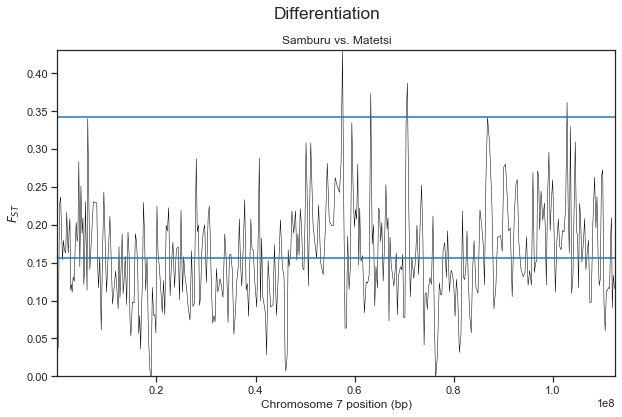

In [15]:
x, y = plot_fst_samburu_matetsi(ac_subpops['samburu'], ac_subpops['matetsi'], pos=pos)
print(np.argmax(y))

In [16]:
gt_strange = callset_vcf['variants/REF'][chrom_index][blen*np.argmax(y): blen*(np.argmax(y)+1)]
''.join(list(gt_strange))

'AAGCTGCTTAATTGAGGGCAGTCGTGGCGGGGAGGACGGCTCGCCCCGATACGATGCATCAATGTACCTAGAGGACGAGTACGAACACCGGGCACTGATATTGCCATTCCTTCCAGGATCATCTCAGCTACAATAGGGAGAGCACGATGGCCCAAGGGCCGGCTCGAGCACAAGACGCAAGGTGTCCTACTGGACCCGGACATTACACGAAGATCTTAAATCCGGTTAAATGTGAACGGTAATGTTATGCGGTATCGTCAATCGAAGAAACGCGTGCCGCAATAGACGTAGCAAAACGGTCGACCAATGGTCCCGACCCGCCGCTGTCTTGAACTGAGTTTGTTAACCGTAGCGGGGCCACAAATAATCTCCATTGTGAACAGCGCGTCAGTCAGCTGATCAAGGGAATTTCAACGCCATGGGGCCGGAGATTGCTGAGACTACAGGTGCAGGTACGGATTCCCCCAGACGGGGACCGACCAGTCGATCGCGACGTATGCCGGTGATCCTGCCTTGGGCGCCAGTAAATGCCACAGCAACTCTTTTGGCGTGCACGCGCGTATCGTGATATGATGCAATCATTCTCAGTCAAGCTATAAATTCTATACTATTTCGTTCGTTTCCAGAATCACCGTTAGTGCGTTTGTTGCACCAGTTCACCTGGACTAGTCCACGGAACCATGGATTACTCCGGACTGCCGGTTACCCAATCGTGGAACACGTTAGGGGGGTAGGATTGACGGCGCGCGTGATGCGATAGCCCGACACCTTTCCATGAAATCCGTTTGTGCGTTAACACCCACGTCGCACCTCCGTAGTGCGGCGGGCACCCCTCGTCTTGTTAAATCGGTTGGGGGCTCCCAGTCGCACAAGGTTCAGCCGGTCAGATGAAGGGCCCACAAGGCCGATTCCCGGGCGAATGCCTCGGCCTAATGCAGCGTGGTATACCAAGTGCGCAGCCCGGAAGCTCCCGCCATGGTTCGGTAAATCTCCGCAGTC

In [17]:
def plot_ic_subpops(ic1, ic2, ic3, ic4, pos, blen=1500):   
    # use the block centres as the X coordinate
    x = allel.moving_statistic(pos, statistic=lambda v: (v[0] + v[-1]) / 2, size=blen)
    y = average(ic1, blen)
    y2 = average(ic2, blen)
    y3 = average(ic3, blen)
    y4 = average(ic4, blen)
    
    # plot
    fig, axs = plt.subplots(4, 1, figsize=(10, 6))
    st = fig.suptitle("Inbreeding Coefficients by Subpopulation", fontsize="x-large")
    plt.subplots_adjust(hspace=0.7)
    #sns.despine(ax=ax, offset=5)
    axs[0].plot(x, y, 'k-', lw=.5)
    axs[0].set_ylabel(r'$F$')
    axs[0].set_xlim(pos.min(), pos.max())
    #axs[0].set_ylim(-0.2, 0.2)
    axs[0].title.set_text('Samburu')
    axs[0].axhline(y=np.percentile(y, 50))
    axs[0].axhline(y=np.percentile(y, 99))
    axs[1].plot(x, y2, 'k-', lw=.5)
    axs[1].set_ylabel(r'$F$')
    axs[1].set_xlim(pos.min(), pos.max())
    #axs[1].set_ylim(-0.2, 0.2)
    axs[1].title.set_text('Matetsi')
    axs[1].axhline(y=np.percentile(y2, 50))
    axs[1].axhline(y=np.percentile(y2, 99))
    axs[2].plot(x, y3, 'k-', lw=.5)
    axs[2].set_ylabel(r'$F$')
    axs[2].set_xlim(pos.min(), pos.max())
    #axs[2].set_ylim(-0.2, 0.2)
    axs[2].title.set_text('Ugalla')
    axs[2].axhline(y=np.percentile(y3, 50))
    axs[2].axhline(y=np.percentile(y3, 99))
    axs[3].plot(x, y4, 'k-', lw=.5)
    axs[3].set_ylabel(r'$F$')
    axs[3].set_xlabel('Chromosome ' + chrom + ' position (bp)')
    axs[3].set_xlim(pos.min(), pos.max())
    #axs[2].set_ylim(-0.2, 0.2)
    axs[3].title.set_text('QENP')
    axs[3].axhline(y=np.percentile(y4, 50))
    axs[3].axhline(y=np.percentile(y4, 99))
    return (x, y, y2, y3, y4)

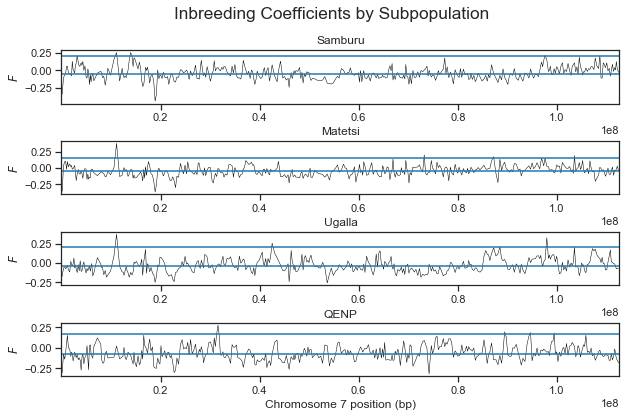

In [18]:
ic_total = allel.inbreeding_coefficient(callset_gt)
ic_samburu = allel.inbreeding_coefficient(samburu_gt)
ic_matetsi = allel.inbreeding_coefficient(matetsi_gt)
ic_ugalla = allel.inbreeding_coefficient(ugalla_gt)
ic_qenp = allel.inbreeding_coefficient(qenp_gt)

if ldprune:
    pos = callset_vcf['variants/POS'][chrom_index][pruned[:, int(chrom)]]
else:
    pos = callset_vcf['variants/POS'][chrom_index]
mask = np.where((pos > 0 * (10**8)) & (pos < 2 * (10**8)))[0]
pos = pos[mask]

x_ic, y_ic, y2_ic, y3_ic, y4_ic = plot_ic_subpops(ic_samburu, ic_matetsi, ic_ugalla, ic_qenp, pos)

In [19]:
def plot_tajimas_d_sam_mat(samburu_ac, matetsi_ac, pos, blen=1500):   
    windows = allel.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], size=blen)
    x = np.asarray(windows).mean(axis=1)
    y, _, _ = allel.windowed_tajima_d(pos, samburu_ac[:], windows=windows)
    y1, _, _ = allel.windowed_tajima_d(pos, matetsi_ac[:], windows=windows)
    
    # plot
    fig, axs = plt.subplots(2, 1, figsize=(10, 6))
    st = fig.suptitle("Tajimas D Between Subspecies", fontsize="x-large")
    plt.subplots_adjust(hspace=0.4)
    #sns.despine(ax=ax, offset=5)
    axs[0].plot(x, y, 'k-', lw=.5)
    axs[0].set_ylabel('$D$')
    axs[0].set_xlim(pos.min(), pos.max())
    axs[0].set_ylim(0, 2)
    axs[0].title.set_text('Samburu')
    axs[0].axhline(y=np.percentile(y, 50))
    axs[0].axhline(y=np.percentile(y, 99))
    axs[1].plot(x, y1, 'k-', lw=.5)
    axs[1].set_ylabel('$D$')
    axs[1].set_xlim(pos.min(), pos.max())
    axs[1].set_ylim(0, 2)
    axs[1].title.set_text('Matetsi')
    axs[1].set_xlabel('Chromosome ' + chrom + ' position (bp)')
    axs[1].axhline(y=np.percentile(y2, 50))
    axs[1].axhline(y=np.percentile(y2, 99))
    return (x, y, y1)

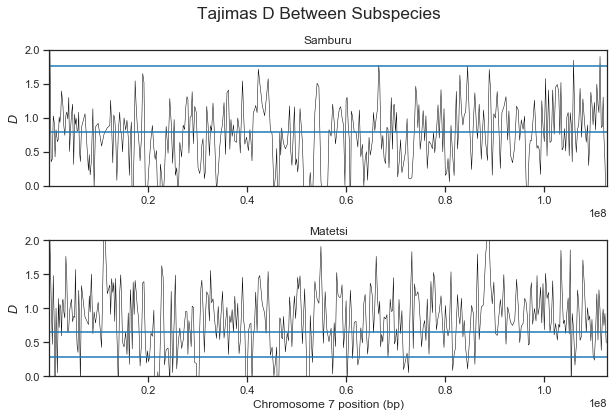

In [20]:
x, y, y1 = plot_tajimas_d_sam_mat(ac_subpops['samburu'], ac_subpops['matetsi'], pos=pos)

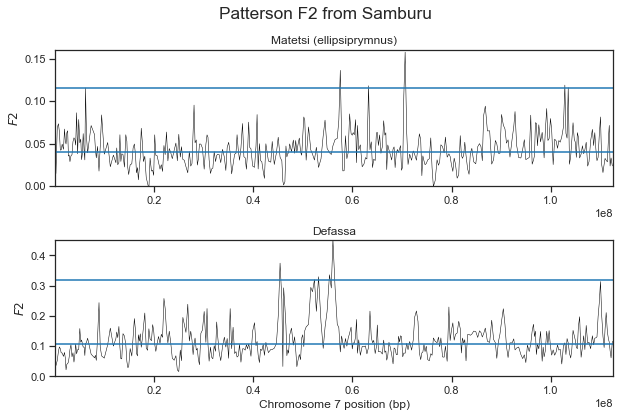

In [21]:
def plot_patterson_f2(ac1, ac2, ac3, pos, blen=1500):
    y = average(allel.patterson_f2(ac1, ac2), blen)
    y1 = average(allel.patterson_f2(ac1, ac3), blen)
    x = allel.moving_statistic(pos, statistic=lambda v: (v[0] + v[-1]) / 2, size=blen)
    # plot
    fig, axs = plt.subplots(2, 1, figsize=(10, 6))
    st = fig.suptitle("Patterson F2 from Samburu", fontsize="x-large")
    plt.subplots_adjust(hspace=0.4)
    #sns.despine(ax=ax, offset=5)
    axs[0].plot(x, y, 'k-', lw=.5)
    axs[0].set_ylabel('$F2$')
    axs[0].set_xlim(pos.min(), pos.max())
    axs[0].set_ylim(0, 0.16)
    axs[0].title.set_text('Matetsi (ellipsiprymnus)')
    axs[0].axhline(y=np.percentile(y, 50))
    axs[0].axhline(y=np.percentile(y, 99))
    axs[1].plot(x, y1, 'k-', lw=.5)
    axs[1].set_ylabel('$F2$')
    axs[1].set_xlim(pos.min(), pos.max())
    axs[1].set_ylim(0, 0.45)
    axs[1].title.set_text('Defassa')
    axs[1].set_xlabel('Chromosome ' + chrom + ' position (bp)')
    axs[1].axhline(y=np.percentile(y1, 50))
    axs[1].axhline(y=np.percentile(y1, 99))
    return (x, y, y1)

x, y, y1 = plot_patterson_f2(ac_subpops['samburu'], ac_subpops['matetsi'], ac_subspecies['defassa'], pos)

In [22]:
def plot_tajimas_d_subpopulations(ac1, ac2, ac3, ac4, pos=pos, blen=1500):
    windows = allel.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], size=blen)
    x = np.asarray(windows).mean(axis=1)
    y, _, _ = allel.windowed_tajima_d(pos, ac1[:], windows=windows)
    y2, _, _ = allel.windowed_tajima_d(pos, ac2[:], windows=windows)
    y3, _, _ = allel.windowed_tajima_d(pos, ac3[:], windows=windows)
    y4, _, _ = allel.windowed_tajima_d(pos, ac4[:], windows=windows)
    
    # plot
    fig, axs = plt.subplots(4, 1, figsize=(10, 6))
    st = fig.suptitle("Tajimas D Between Populations", fontsize="x-large")
    plt.subplots_adjust(hspace=0.8)
    #sns.despine(ax=ax, offset=5)
    axs[0].plot(x, y, 'k-', lw=.5)
    axs[0].set_ylabel('$D$')
    axs[0].set_xlim(pos.min(), pos.max())
    axs[0].set_ylim(y.min(), y.max())
    axs[0].title.set_text('Samburu')
    axs[0].axhline(y=np.percentile(y, 50))
    axs[0].axhline(y=np.percentile(y, 99))
    axs[1].plot(x, y2, 'k-', lw=.5)
    axs[1].set_ylabel('$D$')
    axs[1].set_xlim(pos.min(), pos.max())
    axs[1].set_ylim(y.min(), y.max())
    axs[1].title.set_text('Matetsi')
    axs[1].axhline(y=np.percentile(y2, 50))
    axs[1].axhline(y=np.percentile(y2, 99))
    axs[2].plot(x, y3, 'k-', lw=.5)
    axs[2].set_ylabel('$D$')
    axs[2].set_xlim(pos.min(), pos.max())
    axs[2].set_ylim(y.min(), y.max())
    axs[2].title.set_text('Ugalla')
    axs[2].axhline(y=np.percentile(y3, 50))
    axs[2].axhline(y=np.percentile(y3, 99))
    axs[3].plot(x, y4, 'k-', lw=.5)
    axs[3].set_ylabel('$D$')
    axs[3].set_xlim(pos.min(), pos.max())
    axs[3].set_ylim(y.min(), y.max())
    axs[3].title.set_text('QENP')
    axs[3].set_xlabel('Chromosome ' + chrom + ' position (bp)')
    axs[3].axhline(y=np.percentile(y4, 50))
    axs[3].axhline(y=np.percentile(y4, 99))
    return (x, y, y2, y3, y4)

([0.26355827346286737,
  0.27654681223445093,
  0.23911574527985113,
  0.22077916902283048],
 [0.7946399981617865,
  0.8338010242603644,
  0.7209446810115248,
  0.6656590823781536])

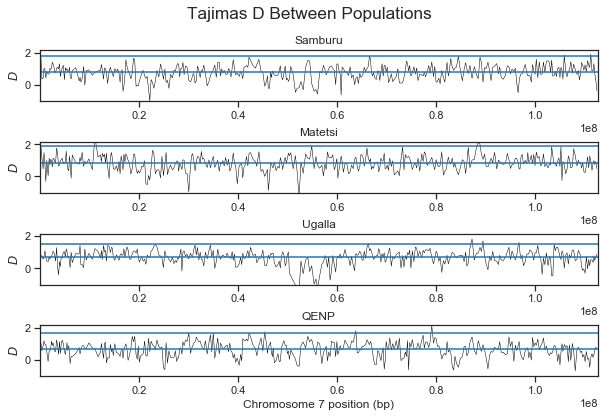

In [23]:
x, y, y2, y3, y4 = plot_tajimas_d_subpopulations(ac1, ac2, ac4, ac6, pos=pos)
median_list = [np.median(y), np.median(y2), np.median(y3), np.median(y4)]
[float(i)/sum(median_list) for i in median_list], [np.median(y), np.median(y2), np.median(y3), np.median(y4)]

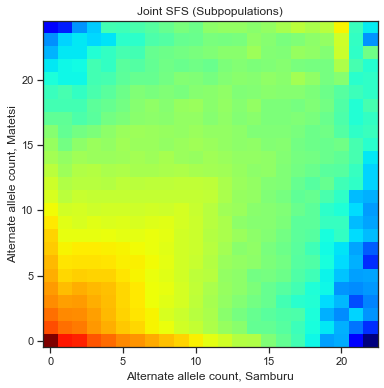

In [24]:
jsfs = allel.joint_sfs(ac_subpops['samburu'][:, 1], ac_subpops['matetsi'][:, 1])
fig, ax = plt.subplots(figsize=(6, 6))
allel.plot_joint_sfs(jsfs, ax=ax)
ax.set_xlabel('Alternate allele count, Samburu')
ax.set_ylabel('Alternate allele count, Matetsi')
plt.title('Joint SFS (Subpopulations)');

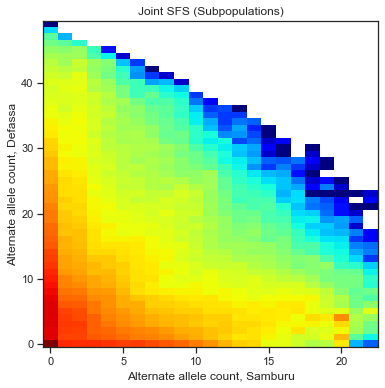

In [25]:
jsfs = allel.joint_sfs(ac_subpops['samburu'][:, 1], ac_subspecies['defassa'][:, 1])
fig, ax = plt.subplots(figsize=(6, 6))
allel.plot_joint_sfs(jsfs, ax=ax)
ax.set_xlabel('Alternate allele count, Samburu')
ax.set_ylabel('Alternate allele count, Defassa')
plt.title('Joint SFS (Subpopulations)');

Text(0, 0.5, 'Second Principal Component (3.83 %)')

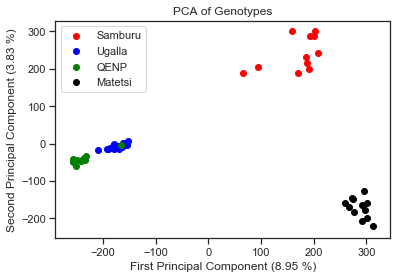

In [26]:
import sklearn.decomposition
from sklearn.preprocessing import StandardScaler

ss = sklearn.preprocessing.StandardScaler()
X = ss.fit_transform(gt.T[0])
pca = sklearn.decomposition.PCA(n_components=2)
reduced = pca.fit_transform(X)

comp1 = round(pca.explained_variance_ratio_[0] * 100, 2)
comp2 = round(pca.explained_variance_ratio_[1] * 100, 2)
var = '%'

plt.scatter(reduced[:, 0][0:11], reduced[:, 1][0:11], color='red', label='Samburu')
plt.scatter(reduced[:, 0][11:26], reduced[:, 1][11:26], color='blue', label='Ugalla')
plt.scatter(reduced[:, 0][26:37], reduced[:, 1][26:37], color='green', label='QENP')
plt.scatter(reduced[:, 0][37:50], reduced[:, 1][37:50], color='black', label='Matetsi')
#plt.xlim((-300, 400))
#plt.axis('equal')
plt.legend()
plt.title('PCA of Genotypes')
plt.xlabel('First Principal Component (%s %s)' %(comp1, var))
plt.ylabel('Second Principal Component (%s %s)' %(comp2, var))

In [27]:
pca.explained_variance_ratio_

array([0.08947226, 0.03826467])

In [28]:
def plot_genotype_frequency(pc, title, labels, missing=False):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    left = np.arange(len(pc))
    palette = sns.color_palette()
    pop2color = {'ellipsiprymnus': palette[0], 'defassa': palette[1]}
    colors = [pop2color[p] for p in samples.Subspecies]
    if missing:
        colors = ['blue', 'blue']
    ax.bar(left, pc, color=colors)
    ax.set_xlim(0, len(pc))
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Percent SNPs')
    ax.set_title(title)
    handles = [matplotlib.patches.Patch(color=palette[0]),
               matplotlib.patches.Patch(color=palette[1])]
    ax.legend(handles=handles, labels=labels, title='Subspecies',
              bbox_to_anchor=(1, 1), loc='upper left')

5.121418864943565

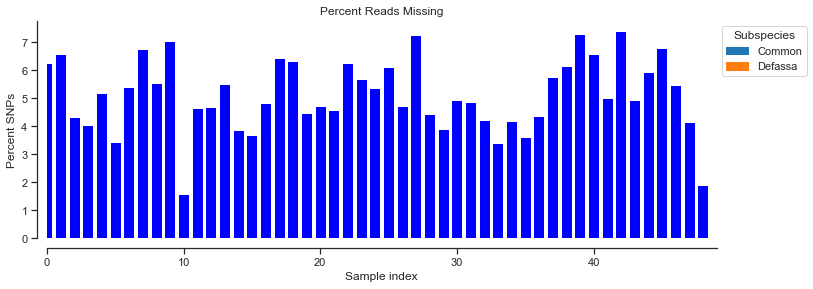

In [29]:
pc_missing = gt.count_missing(axis=0)[:] * 100 / gt.shape[0]
plot_genotype_frequency(pc_missing, 'Percent Reads Missing', ['Common', 'Defassa'], missing=True)
pc_missing.mean()